# Install requirements

In [26]:
!pip install -q open_clip_torch timm torch pillow

import torch, open_clip
from PIL import Image
import numpy as np
import os, sys
import glob, os, re, json, random
from pathlib import Path
import re, math
import matplotlib.pyplot as plt
from collections import Counter

print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.12.12
PyTorch: 2.8.0+cu126
CUDA available: False


# 0) Load dataset

Cloning into '/content/utensils_repo'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 772.98 KiB | 4.27 MiB/s, done.
Resolving deltas: 100% (1/1), done.
total 984K
drwxr-xr-x 3 root root 4.0K Oct 25 16:26 .
drwxr-xr-x 1 root root 4.0K Oct 25 16:26 ..
-rw-r--r-- 1 root root  17K Oct 25 16:26 bowl1.jpg
-rw-r--r-- 1 root root  22K Oct 25 16:26 bowl2.jpg
-rw-r--r-- 1 root root  12K Oct 25 16:26 bowl3.jpg
-rw-r--r-- 1 root root 148K Oct 25 16:26 fork1.jpg
-rw-r--r-- 1 root root  17K Oct 25 16:26 fork2.jpg
-rw-r--r-- 1 root root 133K Oct 25 16:26 fork3.jpg
drwxr-xr-x 8 root root 4.0K Oct 25 16:26 .git
-rw-r--r-- 1 root root  17K Oct 25 16:26 knife1.jpg
-rw-r--r-- 1 root root  21K Oct 25 16:26 knife2.jpg
-rw-r--r-- 1 root root  12K Oct 25 16:26 knife3.jpg
-rw-r--r-- 1 root root  23K Oct 25 16:26 mug1.jp

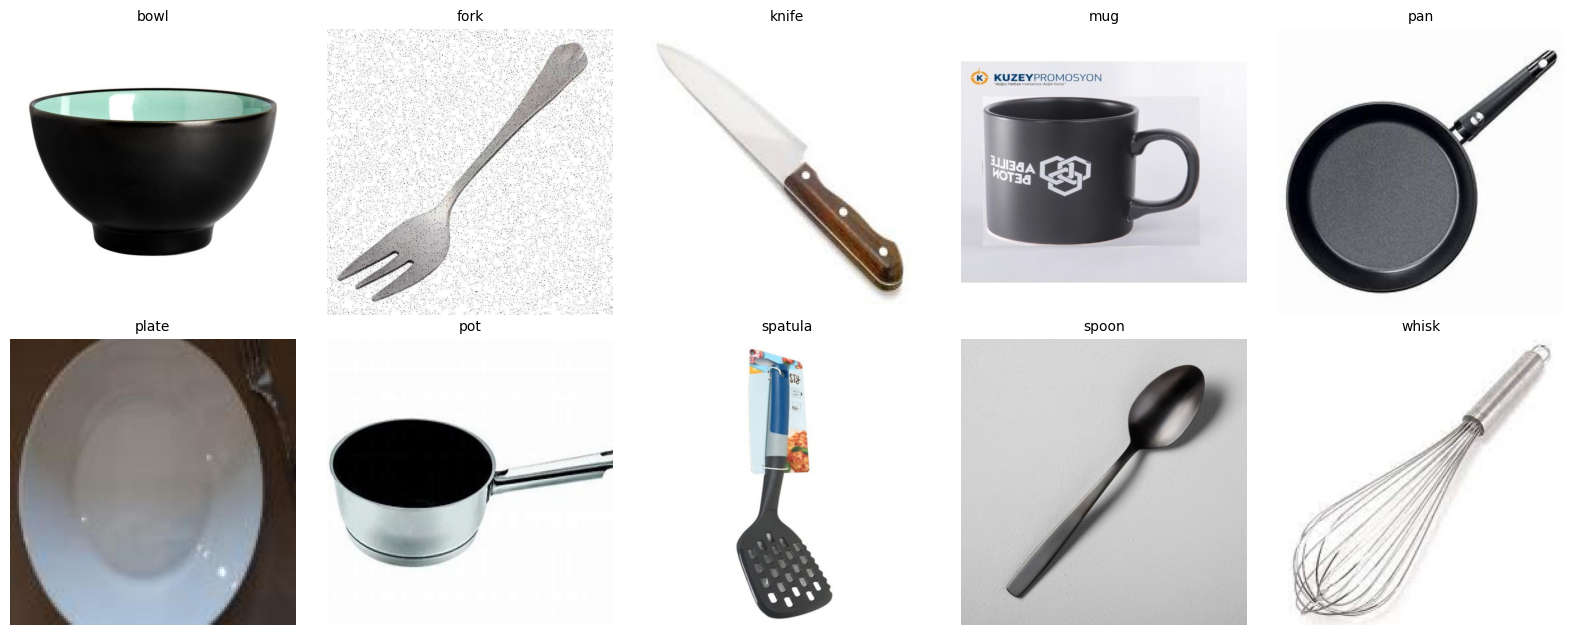

In [23]:
# --- Fetch dataset from GitHub ---
REPO = "samuelinfantee/Vision-Language-Model-Kitchen-utensils-"
REPO_URL = f"https://github.com/{REPO}.git"

!rm -rf /content/utensils_repo
!git clone --depth 1 {REPO_URL} /content/utensils_repo

# Quick sanity
!ls -lah /content/utensils_repo | head -n 20

DATA_ROOT = Path("/content/utensils_repo")
IMG_PATHS = sorted(
    [str(p) for ext in ("*.jpg","*.jpeg","*.png") for p in DATA_ROOT.rglob(ext)]
)

print("Found images:", len(IMG_PATHS))
assert len(IMG_PATHS) == 30, "Expected exactly 30 images."

def infer_class(p):
    """Infer class from filename:"""
    name = Path(p).name.lower()
    m = re.match(r"([a-z_]+)\d+", name) or re.match(r"([a-z_]+)[\._-]", name)
    return (m.group(1) if m else name.split(".")[0]).strip("_-")

# pick first image encountered for each class
first_for_class = {}
for p in IMG_PATHS:
    c = infer_class(p)
    if c not in first_for_class:
        first_for_class[c] = p

classes = sorted(first_for_class.keys())
print(f"Classes ({len(classes)}):", classes)

# display in a tidy grid
n = len(classes)
cols = min(5, n)                 # up to 5 columns
rows = math.ceil(n / cols)
print("Printing 1 image per class: ")
plt.figure(figsize=(3.2*cols, 3.2*rows))
for i, cls in enumerate(classes, 1):
    img = Image.open(first_for_class[cls]).convert("RGB")
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [28]:
#Sanity check: 3 images per class
counts = Counter(infer_class(p) for p in IMG_PATHS)
print("Per-class counts: ", counts)
assert all(v==3 for v in counts.values())

Per-class counts:  Counter({'bowl': 3, 'fork': 3, 'knife': 3, 'mug': 3, 'pan': 3, 'plate': 3, 'pot': 3, 'spatula': 3, 'spoon': 3, 'whisk': 3})


Canonical instruction per class:

In [32]:
Instructions = {
    "bowl":    "Use the bowl to hold, mix, or serve ingredients.",
    "fork":    "Use the fork to spear food and eat solid items.",
    "knife":   "Use the knife to slice or chop ingredients on a cutting board.",
    "mug":     "Use the mug to hold hot drinks by the handle.",
    "pan":     "Use the pan to fry or sauté food on a stovetop.",
    "plate":   "Use the plate to serve and eat food.",
    "pot":     "Use the pot to boil or simmer foods and liquids on a stovetop.",
    "spatula": "Use the spatula to flip or lift food in a pan.",
    "spoon":   "Use the spoon to scoop, serve, or stir liquids and semi-liquids.",
    "whisk":   "Use the whisk to beat or aerate mixtures until smooth or foamy.",
}

# Build the fixed candidate list (order aligned with `classes`)
ALL_TEXTS = [Instructions[c] for c in classes]
print("Candidate set size:", len(ALL_TEXTS))

Candidate set size: 10


# 1) **Load** model and do the preprocessing:

In [33]:
# Pick device and load model + preprocess + tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = 'ViT-B-32-quickgelu'
pretrained = 'laion400m_e32'

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name, pretrained=pretrained
)
tokenizer = open_clip.get_tokenizer(model_name)
model = model.to(device).eval()

print(f"Device: {device}")
print(f"Model: {model_name} | Weights: {pretrained}")

Device: cpu
Model: ViT-B-32-quickgelu | Weights: laion400m_e32


# 2) Rank Images by instructions

In [34]:
def rank_images_by_instructions(image_path, candidate_texts):

    # 1) Transform image to embeddings:
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    #preprocess crops the image to the model's expected input size and normalizes it to CLIPS mean and standard deviation.
    #After preprocess(), image has a single image tensor with shape [Color, Height, Width]. Unsqueeze(0) inserts a new dimension at index 0, turning it into [1, 3, H, W].

    with torch.no_grad(): #We do not need to calculate gradiants because we are not training, just doing inference.
        image_features = model.encode_image(image) #encode_image passes the batch through the vision encoder (ViT-B-32-quickgelu), we get a 2d tensor of shape [batch, d]. d is the model's embedding dim.

    #2) Transform test to embeddings:
    texts = tokenizer(candidate_texts).to(device) #tokenizer turns the list of strings into token IDs with padding/truncation to CLIP's context length. Shape: [num_texts, sequence_length]
    with torch.no_grad():
        text_features = model.encode_text(texts) #Runs the batch through the text encoder, we get a 2d tensor of shape [num_texts, d].

    #3) we calculate the cosine similarity between the image and text features:
    image_features = image_features / image_features.norm(dim=-1, keepdim=True) #Normalize image features
    text_features = text_features / text_features.norm(dim=-1, keepdim=True) #Normalize text features
    similarity = (image_features @ text_features.T).squeeze(0) #shape of [num_texts]. This does matrix multiplication for each text embedding against the image embedding.

    #Now we return the top ranked texts and their similarity scores
    top_index = int(torch.argmax(similarity).item()) #argmax finds the index of the maximum value in the similarity tensor. ".item()" extracts the value as a standard Python number.
    return top_index, similarity.detach().cpu().numpy() #we return top_index and the similarity scores for all candidate texts (detach so no gradiants are attached, and me move it to CPU, and transform the CPU tensor to NumPy array).



# 3) Evaluation Loop

In [35]:
def evaluate():
  correct = 0 #Correctly classified
  total = 0
  for image in IMG_PATHS:
    gold_class = infer_class(image) #Class (like pot, fork, etc,)
    gold_instruction = Instructions[gold_class] #The correct instruction for that class
    gold_index = ALL_TEXTS.index(gold_instruction) #The correct index in the candidate list

    predicted_index, similarities = rank_images_by_instructions(image, ALL_TEXTS) #Predict using our previously created function.

    correct += int(predicted_index == gold_index)
    total += 1

  accuracy = correct/max(total,1)
  print(f"Top-1 accuracy: {correct}/{total} ({100*accuracy:.2f}%)")
  return accuracy

#run
_ = evaluate()


Top-1 accuracy: 27/30 (90.00%)


# 4) Examples


Image: whisk2.jpg
Gold instruction: Use the whisk to beat or aerate mixtures until smooth or foamy.
Prediction: 9
   - idx= 9 score=0.307  Use the whisk to beat or aerate mixtures until smooth or foamy.
   - idx= 8 score=0.221  Use the spoon to scoop, serve, or stir liquids and semi-liquids.
   - idx= 1 score=0.188  Use the fork to spear food and eat solid items.

Image: spoon2.jpg
Gold instruction: Use the spoon to scoop, serve, or stir liquids and semi-liquids.
Prediction: 8
   - idx= 8 score=0.228  Use the spoon to scoop, serve, or stir liquids and semi-liquids.
   - idx= 1 score=0.206  Use the fork to spear food and eat solid items.
   - idx= 7 score=0.189  Use the spatula to flip or lift food in a pan.

Image: knife2.jpg
Gold instruction: Use the knife to slice or chop ingredients on a cutting board.
Prediction: 1
   - idx= 1 score=0.215  Use the fork to spear food and eat solid items.
   - idx= 7 score=0.187  Use the spatula to flip or lift food in a pan.
   - idx= 8 score=0.182

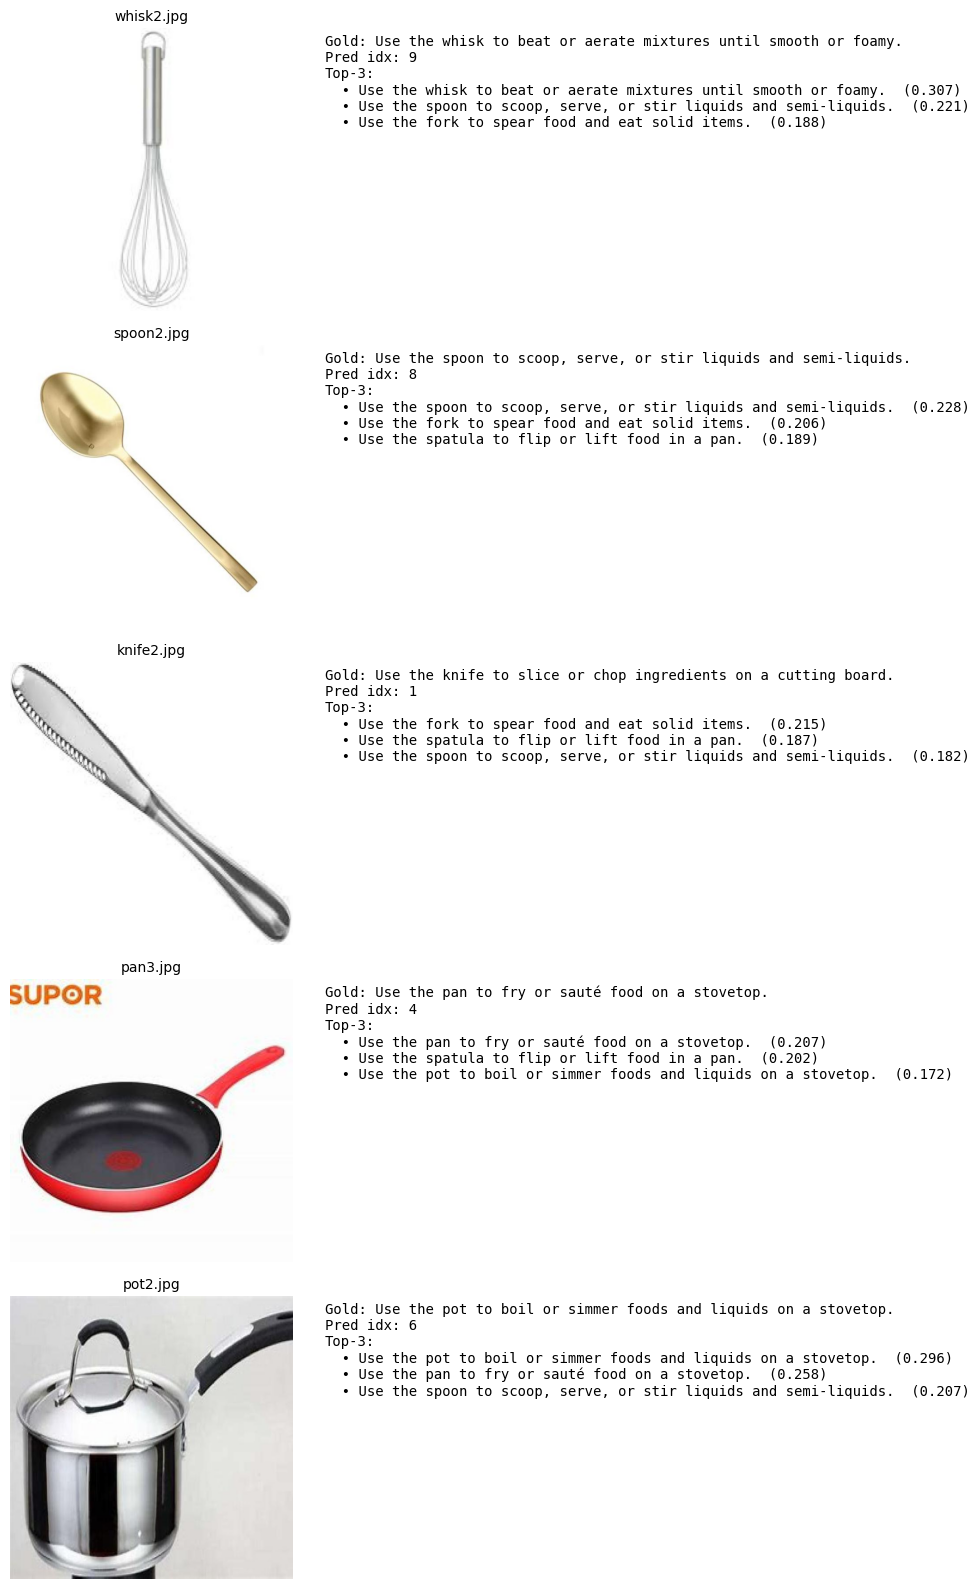

In [41]:
def examples(k=5):
    sample_images = random.sample(IMG_PATHS, k=min(k, len(IMG_PATHS)))
    rows = len(sample_images)
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3.2*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, image in enumerate(sample_images):
        gold_class = infer_class(image)
        gold_instruction = Instructions[gold_class]
        gold_index = ALL_TEXTS.index(gold_instruction)

        predicted_index, scores = rank_images_by_instructions(image, ALL_TEXTS)
        top3 = np.argsort(scores)[::-1][:3]

        print("\nImage:", os.path.basename(image))
        print("Gold instruction:", gold_instruction)
        print("Prediction:", predicted_index)
        for j in top3:
            print(f"   - idx={j:>2} score={scores[j]:.3f}  {ALL_TEXTS[j]}")

        # ---- Left: image
        img = Image.open(image).convert("RGB")
        axes[r, 0].imshow(img)
        axes[r, 0].set_title(os.path.basename(image), fontsize=10)
        axes[r, 0].axis("off")

        # ---- Right: text block (gold + pred + top-3)
        axes[r, 1].axis("off")
        text_lines = [
            f"Gold: {gold_instruction}",
            f"Pred idx: {predicted_index}",
            "Top-3:"
        ] + [f"  • {ALL_TEXTS[j]}  ({scores[j]:.3f})" for j in top3]
        axes[r, 1].text(0.01, 0.98, "\n".join(text_lines),
                        va='top', ha='left', fontsize=10, family='monospace')

    plt.tight_layout()
    plt.show()

# Run
examples(5)